In [28]:
from brainways_lightning_module import BrainwaysLightningModule
from brainways_datamodule import BrainwaysDataModule
from main import BrainwaysLightningCLI
import matplotlib.pyplot as plt
import random
from constants import AP_LIMITS
from tqdm import tqdm
import torch
from brainways_model import BrainwaysModel
from single_dataset import BrainwaysSingleDataset
from lightning import Trainer
from dataset_utils import load_atlas_reference, transform_atlas_volume
from backbones.efficientnet_backbone import EfficientNetBackbone

In [29]:
def get_display_image(image: torch.Tensor):
    image = (image - torch.min(image)) / (torch.max(image) - torch.min(image))
    return image.squeeze().permute(1, 2, 0).cpu().numpy()

In [34]:
trainer = Trainer(precision="16-mixed")

with trainer.init_module(empty_init=True):
    transformed_atlases = {
        atlas_name: transform_atlas_volume(
            load_atlas_reference(atlas_name),
            transform=BrainwaysDataModule.define_eval_transform(),
        )
        for atlas_name in ["whs_sd_rat_39um", "allen_mouse_25um"]
    }
    
    dataset = BrainwaysSingleDataset(
        data_sources=[
            {
                "images_path": "/home/ben/python/brm2/data/deepslice_processed/images",
                "labels_path": (
                    "/home/ben/python/brm2/data/deepslice_processed/labels.csv"
                ),
                "atlas_name": "allen_mouse_25um",
            }
            # {
            #     "images_path": "/home/ben/brainways/brainways-reg-model/data/real/test/images",
            #     "labels_path": (
            #         "/home/ben/brainways/brainways-reg-model/data/real/test/labels.csv"
            #     ),
            #     "atlas_name": "whs_sd_rat_39um",
            # }
        ],
        transform=BrainwaysDataModule.define_eval_transform(),
    )
    model = BrainwaysLightningModule.load_from_checkpoint(
        "/home/ben/python/brm2/lightning_logs/version_174/checkpoints/epoch=0-step=5000.ckpt",
        backbone=EfficientNetBackbone(),
        pred_atlases=transformed_atlases,
    )
    model.freeze()
    model = model.model

Using 16bit Automatic Mixed Precision (AMP)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/ben/miniconda3/envs/brm-dinov2/lib/python3.11/site-packages/lightning/pytorch/trainer/trainer.py:1106: `trainer.init_module` cannot fully support proper instantiation of your model with the `SingleDeviceStrategy` strategy. Please instantiate your model inside the`LightningModule.configure_model` hook instead


Bg_atlasapi: whs_sd_rat_39um version 1.0 is not the latest available (1.1). To update the atlas run in the 
terminal:
    brainglobe update -a whs_sd_rat_39um

/home/ben/miniconda3/envs/brm-dinov2/lib/python3.11/site-packages/albumentations/augmentations/functional.py:164: RuntimeWarning: invalid value encountered in divide
  normalized_img = (img - img_min) / (img_max - img_min)
/home/ben/miniconda3/envs/brm-dinov2/lib/python3.11/site-packages/albumentations/augmentations/functional.py:1071: RuntimeWarning: invalid value encountered in cast
  return (img * max_value).astype(dtype)


121: /home/ben/python/brm2/data/deepslice_processed/images/641_2002_2568_NM01_s129_10x_A.jpg


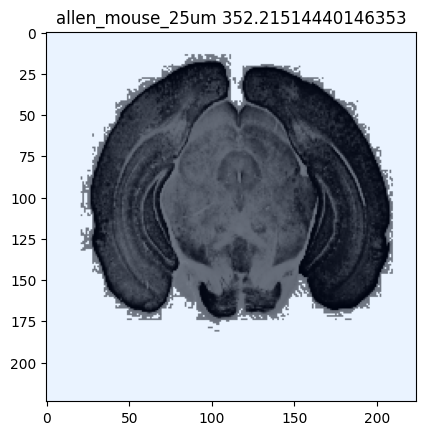

In [103]:
# dataset = cli.datamodule.test_dataset
index = random.randint(0, len(dataset))
sample = dataset[index]
image = sample["image"].to("cuda")
atlas_name = sample["atlas_name"]
min_ap, max_ap = AP_LIMITS[atlas_name]
label = max_ap - sample["ap"]
print(f"{index}: {sample['filename']}")
_ = plt.imshow(get_display_image(image))
_ = plt.title(f"{atlas_name} {label}")

100%|██████████| 66/66 [00:00<00:00, 69.63it/s]


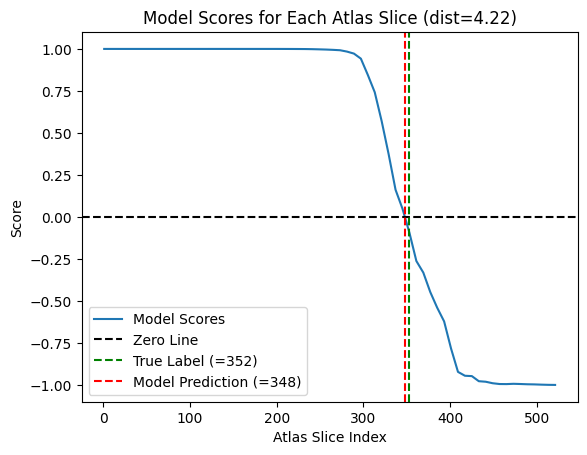

In [104]:
atlas_reference = model.get_atlas(atlas_name)
pred = model.predict(image.unsqueeze(0), atlas_name=atlas_name).cpu().item()

scores = []
xs = list(range(min_ap, max_ap, 8))

# Iterate over each slice in the atlas
for i in tqdm(xs):
    atlas_slice = atlas_reference[i]
    # Run the model on the image and atlas slice
    output = model(image.unsqueeze(0), atlas_slice.unsqueeze(0))

    # Assuming that the output is a score, append it to the scores list
    scores.append(output["preds"].item())

# Plot the scores
plt.plot(xs, scores)
plt.axhline(y=0, color="k", linestyle="--")
plt.axvline(x=label, color="g", linestyle="--")
plt.axvline(x=pred, color="r", linestyle="--")
plt.legend(
    [
        "Model Scores",
        "Zero Line",
        f"True Label (={int(label)})",
        f"Model Prediction (={pred})",
    ]
)
plt.xlabel("Atlas Slice Index")
plt.ylabel("Score")
plt.title(f"Model Scores for Each Atlas Slice (dist={abs(pred-label):.2f})")
plt.show()

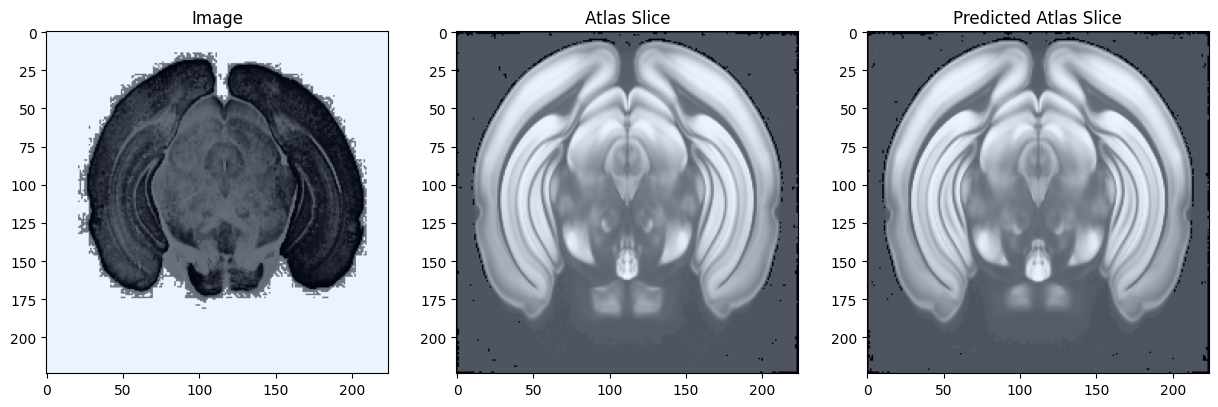

In [105]:
# show pred and atlas slices side by side
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(get_display_image(image))
plt.title("Image")
plt.subplot(1, 3, 2)
plt.imshow(get_display_image(atlas_reference[int(label)]))
plt.title("Atlas Slice")
plt.subplot(1, 3, 3)
plt.imshow(get_display_image(atlas_reference[pred]))
plt.title("Predicted Atlas Slice")
plt.show()